# Country results for Heatwaves

Calculate N exposures for each country

Optional: calculate exposure weighted heatwave length

1.2 Heatwaves

- Australia
- Brazil
- Canada
- EU28
- France
- Germany
- India
- Spain
- Sweden
- UK/GB
- USA (Hawaii? Alaska? -> check with country author)



In [1]:
%matplotlib inline

from pathlib import Path

import numpy as np
import scipy as sp
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import geopandas as gpd

from tqdm import tqdm_notebook

import population_tools

from config import (DATA_SRC, POP_DATA_SRC)

In [2]:
MAX_YEAR = 2017
REFERENCE_YEAR_START = 1986
REFERENCE_YEAR_END = 2005

RESULTS_FOLDER = Path('./results/lancet2018/countries/1.2 heatwaves')
RESULTS_FOLDER.mkdir(parents=True, exist_ok=True)

COUNTRY_SHAPEFILE = DATA_SRC / 'GIS' / 'world'/ 'ne_50m_admin_0_countries' / 'ne_50m_admin_0_countries.shp'

COUNTRY_RASTER_FILES = DATA_SRC/ 'lancet/countries_rasters/*.nc'

# LIMIT to the following countries for now
SELECTED_COUNTRIES = ['AU', 'BR', 'CA', 'CN', 'DE', 'ES', 'EU', 'FR', 'GB','IN', 'SE', 'US', 'NL', 'PL']
SELECTED_COUNTRIES.sort()

## Load country data

In [3]:
COUNTRIES = gpd.read_file(str(COUNTRY_SHAPEFILE))

In [4]:
COUNTRIES_NAMES = COUNTRIES.set_index('iso_a2').sovereignt
COUNTRIES_NAMES['EU'] = 'EU28'

In [5]:
COUNTRIES_RASTER = xr.open_mfdataset(str(COUNTRY_RASTER_FILES))

## Load age percentage rasters

In [7]:
pct_age_rasters = xr.open_dataarray(DATA_SRC / 'lancet' / 'population_over_65.nc')


## Heatwave change

### Load data


In [9]:
heatwaves_lengths_delta = xr.open_dataarray(DATA_SRC / 'lancet'/'heatwaves_lengths_delta.nc')
# heatwaves_counts_delta = xr.open_dataarray(DATA_SRC / 'lancet'/'heatwaves_counts_delta.nc')

In [8]:
# Exposure grid
heatwaves_pop_events = xr.open_dataarray(DATA_SRC / 'lancet' / f'heatwave_exposure_events_change_2000-{MAX_YEAR}.nc')

In [14]:
# Reference lengths (global average)
heatwaves_lengths_ts = xr.open_dataarray(DATA_SRC / 'lancet'/'heatwaves_lengths_delta_ts.nc')

# Reference exposure weighted lengths time series
heatwaves_l_pop_ts = xr.open_dataarray(str(DATA_SRC / 'lancet' / 'heatwave_l_change_pop.nc'))

In [15]:
# Dataframe with previously calculated global results
global_reference = pd.concat([heatwaves_l_pop_ts.to_dataframe('Mean exposure weighted change'), 
                              heatwaves_lengths_ts.to_dataframe('Mean global change')], axis=1)

## Exposures by country


For Heatwaves, want the same plots as were in the original paper

- the heatwave exposure total number change (not normalised)
- the heatwave length change


# NOTE: modified to generate all countries

In [6]:
global_exposure_reference = pd.read_csv(Path('results/lancet2018/global/1.2 heatwaves') / f'heatwaves_n_exposure_change_2000-{MAX_YEAR}.csv').set_index('year')

In [17]:
# Note: for the exposures, no need to re-project because we don't need to normalise by country population.
# The totals are fine.
exposure_results = []
# for iso_a2 in tqdm_notebook(SELECTED_COUNTRIES):
    
for iso_a2 in tqdm_notebook(COUNTRIES_NAMES.keys()):
    
    if iso_a2 in  COUNTRIES_RASTER.iso_a2.values:

        country_mask = COUNTRIES_RASTER.sel(iso_a2=iso_a2, drop=True).country_mask.load()
        country_exposures_ts = (heatwaves_pop_events * country_mask).sum(dim=['latitude', 'longitude'])

        exposure_results.append(country_exposures_ts.to_dataframe(iso_a2))
    
exposure_results = pd.concat(exposure_results, axis=1)

In [18]:
exposure_results.to_excel(RESULTS_FOLDER / 'heatwave_exposures.xlsx', 
                          sheet_name='exposure change by country')

In [20]:
exposure_results.drop('EU', axis=1).sum(axis=1)

year
2000   -8.452748e+06
2001   -3.280413e+06
2002    9.261906e+06
2003    4.875324e+07
2004   -1.773739e+07
2005    2.002605e+07
2006    4.528548e+07
2007    2.563199e+07
2008   -2.247761e+07
2009    5.500307e+06
2010    1.751257e+08
2011    3.012289e+07
2012    5.589097e+07
2013    7.938988e+07
2014    5.306496e+07
2015    2.150996e+08
2016    1.434678e+08
2017    1.619155e+08
dtype: float64

In [43]:
exposure_results = pd.read_excel(RESULTS_FOLDER / 'heatwave_exposures.xlsx', 
                          sheet_name='exposure change by country').set_index('year')

In [56]:
set(COUNTRIES_NAMES.keys()) - set(exposure_results.columns)

{'-99', 'AQ', 'GS', 'HM', 'IO', 'TF', 'TW'}

Filter countries with area less than the resolution of the weather grid,  i.e. where country area in 'square degrees' is less than 0.5*0.5 = 0.25 square degrees

In [66]:
tiny_states = set(COUNTRIES[COUNTRIES.geometry.area < 0.25].iso_a2) & set(exposure_results.columns)
tiny_state_ids = COUNTRIES[COUNTRIES.iso_a2.isin(tiny_states)][['iso_a2', 'name']]
tiny_state_ids.to_excel(RESULTS_FOLDER / 'small_area_states_ids.xlsx', index=False)

In [46]:
ax = exposure_results.plot(color='C0',alpha=0.1, legend=False)
global_exposure_reference['heatwave_exposure_events'].plot(color='C1', ax=ax)
# plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


In [13]:
EXPOSURES_PLOTS = RESULTS_FOLDER / 'exposures_plots'
EXPOSURES_PLOTS.mkdir(exist_ok=True)

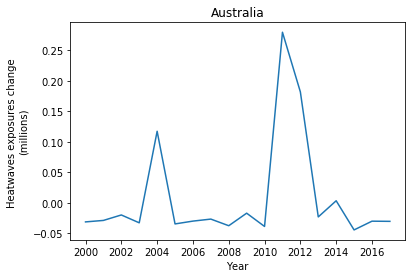

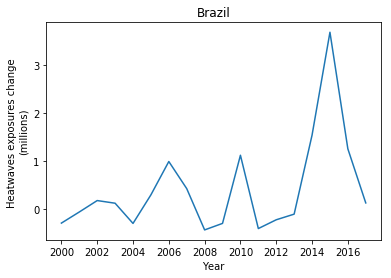

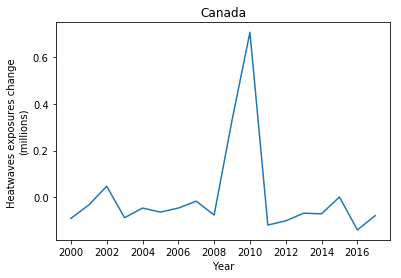

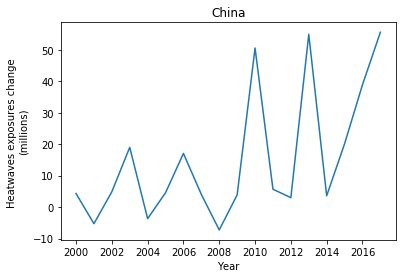

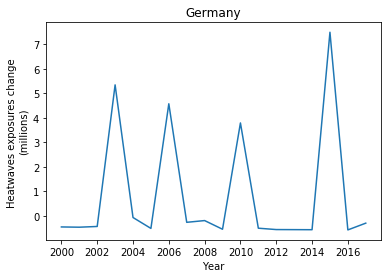

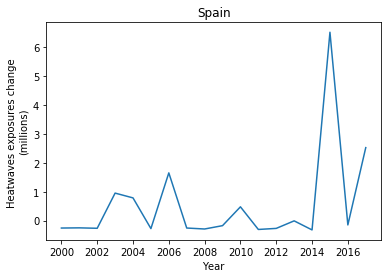

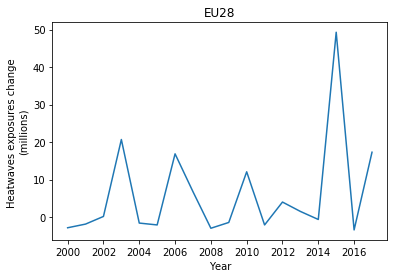

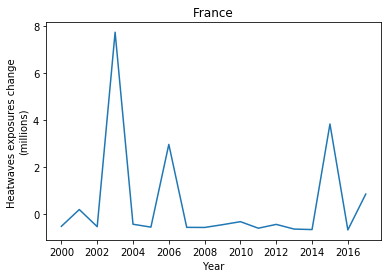

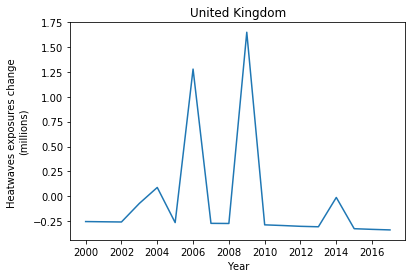

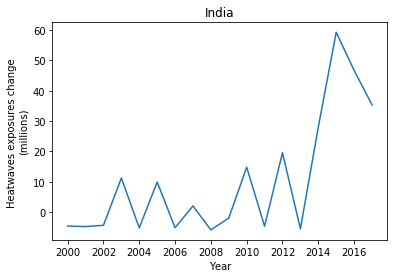

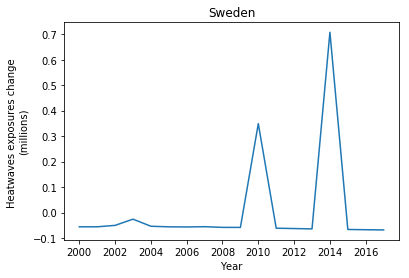

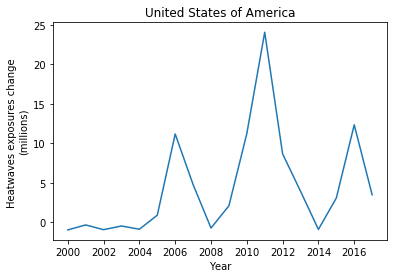

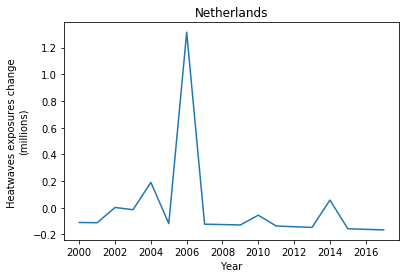

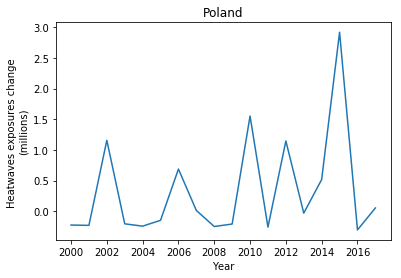

In [14]:
for h in exposure_results:
    
    country_name = COUNTRIES_NAMES[h] 
    
    f, ax = plt.subplots()
    (exposure_results[h] / 1e6).plot(color='C0', ax=ax,legend=False, 
                                        label=f'{country_name} exposures')

    ax.set_xlabel('Year')
    ax.set_ylabel('''Heatwaves exposures change \n(millions)''')
    ax.set_title(f'{country_name}')
    plt.xticks(exposure_results.index[0::2])

    
    f.savefig(EXPOSURES_PLOTS / f'{h}_heatwaves_exposure_change_2000-{MAX_YEAR}.png', 
              dpi=300, bbox_inches='tight')





In [8]:
heatwaves_counts = xr.open_dataarray(DATA_SRC / 'lancet'/'heatwaves_counts_all_years.nc')

In [9]:
heatwaves_counts = heatwaves_counts.sel(year=slice(2000, MAX_YEAR))

In [10]:
heatwaves_pop_events_abs_ts = population_tools.project_to_population(heatwaves_counts, 
                                                             pct_age_rasters, 
                                                             norm=False,
                                                             get_ts=True,
                                                             end_year=MAX_YEAR)

## Heatwave length exposure weighted change

Need to re-calculate so that we normalise by the country population

In [15]:
COUNTRY_RASTER_CLIM_FILES = DATA_SRC/ 'lancet/countries_climate_rasters/*.nc'
COUNTRIES_RASTER_CLIM = xr.open_mfdataset(str(COUNTRY_RASTER_CLIM_FILES))

In [16]:
length_ref_results = []
for iso_a2 in tqdm_notebook(SELECTED_COUNTRIES):
    
    country_mask = COUNTRIES_RASTER_CLIM.sel(iso_a2=iso_a2).country_mask.load().drop('iso_a2')
    country_lengths_ts = (heatwaves_lengths_delta * country_mask.where(country_mask > 0)).mean(dim=['latitude', 'longitude'])
    
    length_ref_results.append(country_lengths_ts.to_dataframe(iso_a2))
    
length_ref_results = pd.concat(length_ref_results,axis=1)

In [17]:
length_results = []
for iso_a2 in tqdm_notebook(SELECTED_COUNTRIES):
    
    country_mask = COUNTRIES_RASTER.sel(iso_a2=iso_a2).country_mask.load().drop('iso_a2')
    country_exposures_ts = population_tools.project_to_population(heatwaves_lengths_delta,
                                                                  weights=country_mask.where(country_mask > 0) * pct_age_rasters,
                                                                  norm=True, 
                                                                  end_year=MAX_YEAR)
    
    length_results.append(country_exposures_ts.to_dataframe(iso_a2))
    
length_results = pd.concat(length_results,axis=1)

In [18]:
with pd.ExcelWriter(RESULTS_FOLDER / 'heatwave_length_exposure_weighted.xlsx') as writer:
    length_results.to_excel(writer, sheet_name='weighted heatwave length change')    
    global_reference.to_excel(writer, sheet_name='global reference')


In [19]:
LENGTHS_PLOTS = RESULTS_FOLDER / 'lengths_plots'
LENGTHS_PLOTS.mkdir(exist_ok=True)

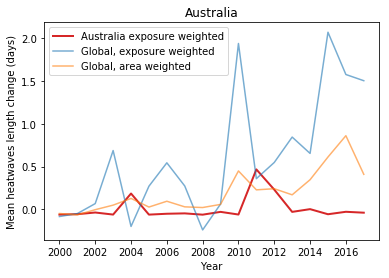

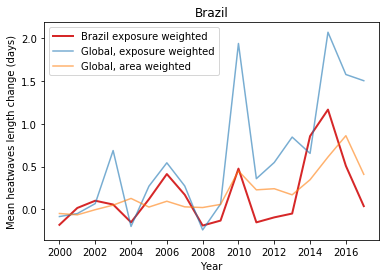

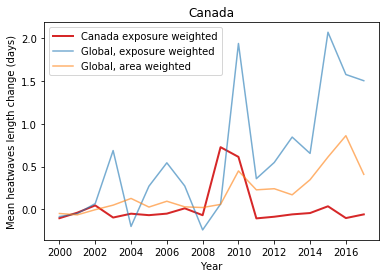

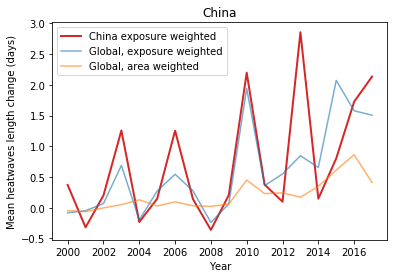

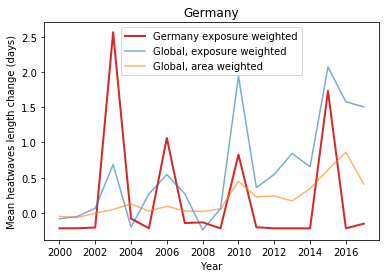

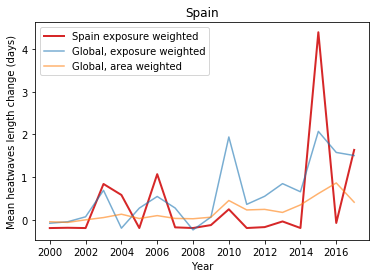

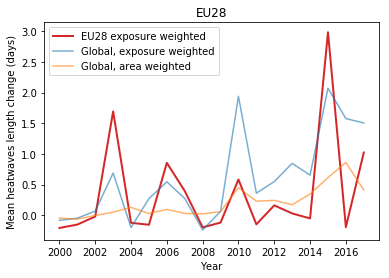

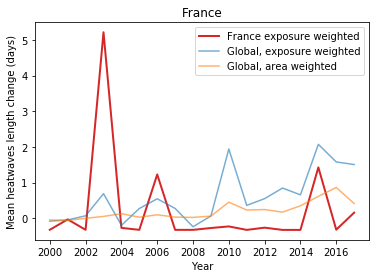

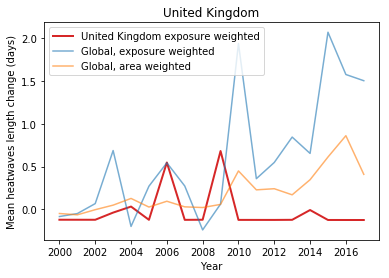

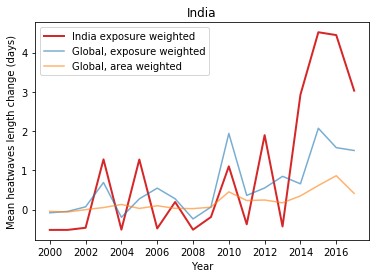

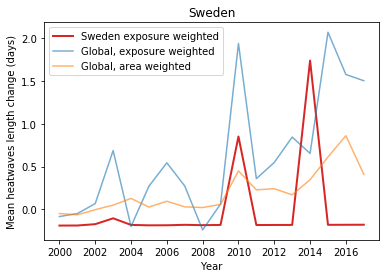

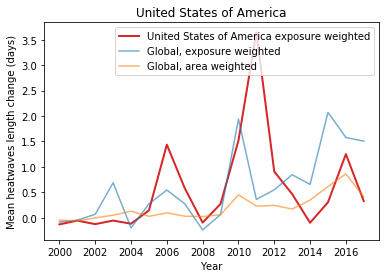

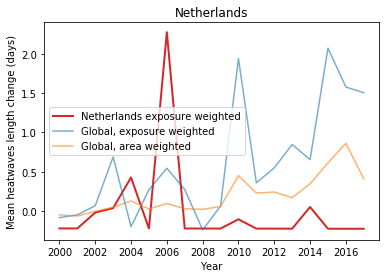

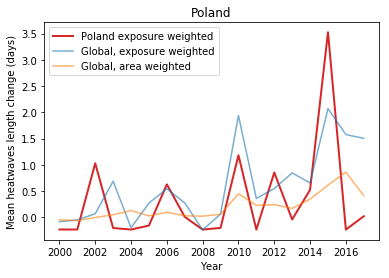

In [20]:
for h in length_results:
    
    country_name = COUNTRIES_NAMES[h]
    
    f, ax = plt.subplots()
    length_results[h].plot(color='C3', 
                           linewidth=2,
                           ax=ax,legend=False,
                           label=f'{country_name} exposure weighted')
#     length_ref_results[h].plot(color='C1',label=f'{country_name} area weighted', ax=ax)
    heatwaves_l_pop_ts.plot(color='C0',
                            alpha=0.6,
                            label='Global, exposure weighted', 
                            ax=ax)
    heatwaves_lengths_ts.plot(color='C1',
                              alpha=0.6,
                              label='Global, area weighted',
                              ax=ax)

    ax.set_xlabel('Year')
    ax.set_ylabel('''Mean heatwaves length change (days)''')
    ax.set_title(f'{country_name}')
    plt.legend()
    plt.xticks(length_results.index[0::2])
    
    f.savefig(LENGTHS_PLOTS / f'{h}_heatwaves_mean_length_exposure_2000-{MAX_YEAR}.png', 
              dpi=300, bbox_inches='tight')





## Map plots

- Need to find a 2d representation that gives a reasonable impression of the trend, with particular focus on the spatial distribution of the trend
- Especially for heatwaves which are rather random, taking the change for a single year is rather arbitrary. Instead we need to apply a reduction operation to get a 2D array from the time series
- I think doing a simple average of the total heatwave exposure change relative to the historical average should work. This gives for each pixel the average change (increase) in heat wave exposure.


In [41]:
heatwaves_counts_delta_mean = heatwaves_counts_delta.mean(dim='year')
heatwaves_counts_delta_mean.name = 'mean_change_n_heatwaves'

In [42]:
heatwaves_exposure_delta_mean = heatwaves_exposure_delta.mean(dim='year')

In [45]:
borders = cartopy.feature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', '10m')

In [46]:
def plot_country(country_iso):
    if country_iso in eu_clip.adm0_a3.values:
        print(country_iso)
        tmp = eu_clip.set_index('adm0_a3')
    else:
        tmp = countries.set_index('adm0_a3')
    
    country_name = tmp.loc[country_iso]['name']
#     bounds = countries[countries.iso_a2 == country_iso].geometry.bounds.iloc[0]

    minx, miny, maxx, maxy = tmp.loc[country_iso].geometry.bounds


    bounds = (minx, maxx, miny, maxy)

    f = plt.figure(figsize=(6,3))

    ax = plt.axes(projection=ccrs.PlateCarree())
    heatwaves_exposure_delta_mean.plot.pcolormesh(ax=ax,
                              transform=ccrs.PlateCarree(),
                                                  robust=True,
                              cbar_kwargs=dict(label='Change in exposures'),
                              cmap='RdBu_r'
                             )
    ax.coastlines()

    ax.add_feature(cartopy.feature.BORDERS, linestyle=':')

    ax.set_extent(bounds)
    plt.tight_layout()
    plt.title(f'''{country_name} mean change in heatwave exposures per year
      in 2000-2016 period relative to historical average''')
    
    return f, ax
    # f.savefig('heatwaves_delta.png', dpi=300, bbox_inches='tight')




GBR
FRA
SWE


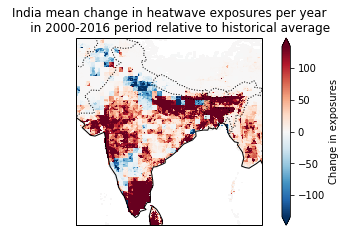

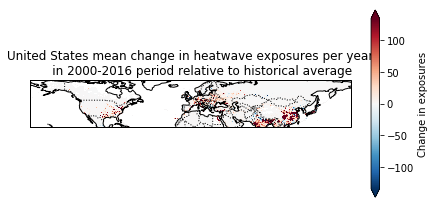

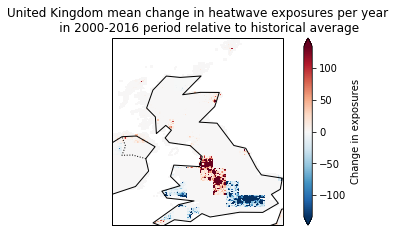

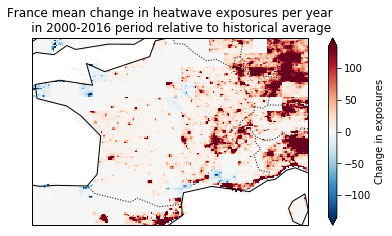

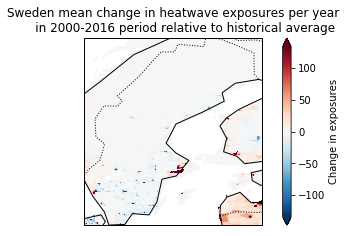

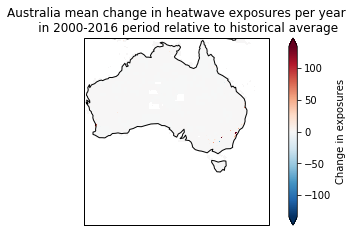

In [47]:
# TODO adjust bounds esp for france
for country_iso in select_country_a3:
    f, ax = plot_country(country_iso)
    f.savefig(str(COUNTRY_BRIEFS / 'heatwaves' / f'{country_iso}_heatwaves_delta_map.png'), dpi=300, bbox_inches='tight')


### Do USA

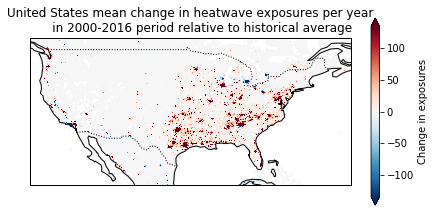

In [48]:
country_iso = 'USA'
f, ax = plot_country(country_iso)

ax.set_extent((-126.5, -62.5, 22, 47))
f.savefig(str(COUNTRY_BRIEFS / 'heatwaves' / f'{country_iso}_heatwaves_delta_map.png'), dpi=300, bbox_inches='tight')


# -170.2,17.7,-50.6,74.1

### Do Australia

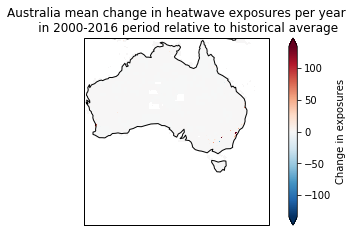

In [49]:
country_iso = 'AUS'
f, ax = plot_country(country_iso)
f.savefig(str(COUNTRY_BRIEFS / 'heatwaves' / f'{country_iso}_heatwaves_delta_map.png'), dpi=300, bbox_inches='tight')




In [15]:
results = [do_exposure(row, heatwaves_lengths_delta, countries_raster_expo, norm=False) 
           for idx, row in tqdm_notebook(countries.iterrows(), total=len(countries)) if row.iso_a3 in ['AUS']]

aus_hw_total_expo_by_country = pd.concat(results, axis=1)

In [18]:
aus_hw_total_expo_by_country.to_csv(COUNTRY_BRIEFS / 'heatwaves' / 'aus_total_exposure.csv')

In [13]:
results = [do_exposure(row, heatwaves_lengths_delta, countries_raster_expo) 
           for idx, row in tqdm_notebook(countries.iterrows(), total=len(countries)) if row.iso_a3 in ['AUS']]

aus_hw_length_expo_by_country = pd.concat(results, axis=1)

In [19]:
aus_hw_length_expo_by_country.to_csv(COUNTRY_BRIEFS / 'heatwaves' / 'aus_heatwave_mean_length_exposure.csv')